In [11]:
import pandas as pd 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
import numpy as np
# Reading the data 
data = pd.read_csv('Sentiment.csv')
# Taking the required columns
data = data[['text','sentiment']]

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
data.head(5)

,text,sentiment
0,rt nancyleegrahn how did everyone feel about t...,Neutral
1,rt scottwalker didnt catch the full gopdebate ...,Positive
2,rt tjmshow no mention of tamir rice and the go...,Neutral
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive


In [12]:
max_features = 2000
# Applying Tokenizer
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

X = pad_sequences(X)

embed_dim = 128
lstm_out = 196

# Defining model
def createmodel():
    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

# Declaring label encoder
labelencoder = LabelEncoder()
# Applying the label encoder created
integer_encoded = labelencoder.fit_transform(data['sentiment'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)


batch_size = 32
model = createmodel()
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2)
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
print("Score:", score)
print("Accuracy:",acc)
print("Metrics:", model.metrics_names)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
 - 26s - loss: 0.8376 - accuracy: 0.6421
Score: 0.7542982205468632
Accuracy: 0.6727828979492188
Metrics: ['loss', 'accuracy']


In [16]:
# Converting model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serializing weights to HDF5
model.save_weights("model.h5")

# Loading the model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Loading weights into new model
loaded_model.load_weights("model.h5")

# Evaluating the model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 69.47%


In [17]:
tweet = ['A lot of good things are happening. We are respected again throughout the world, and thats a great thing.@realDonaldTrump']

# Vectorizing the tweet by the pre-fitted tokenizer instance
tweet = tokenizer.texts_to_sequences(tweet)

# Padding the tweet to have exactly the same shape as `embedding_2` input
tweet = pad_sequences(tweet, maxlen=28, dtype='int32', value=0)
print(tweet)
sentiment = model.predict(tweet, batch_size=1, verbose=2)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   8 439   6 144 290  36  31
   36 372   2 347   9 261   8 151 264  24]]
[0.64860666 0.20737901 0.14401425]
negative


In [18]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=32)
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
from keras.models import load_model
print("Score:", score)
print("Accuracy:",acc)

Train on 9293 samples, validate on 4578 samples
Epoch 1/5
9293/9293 [==============================] - 32s 3ms/step - loss: 0.6890 - accuracy: 0.7081 - val_loss: 0.7461 - val_accuracy: 0.6837
Epoch 2/5
9293/9293 [==============================] - 31s 3ms/step - loss: 0.6208 - accuracy: 0.7413 - val_loss: 0.7457 - val_accuracy: 0.6859
Epoch 3/5
9293/9293 [==============================] - 31s 3ms/step - loss: 0.5731 - accuracy: 0.7632 - val_loss: 0.7721 - val_accuracy: 0.6817
Epoch 4/5
9293/9293 [==============================] - 31s 3ms/step - loss: 0.5340 - accuracy: 0.7797 - val_loss: 0.8168 - val_accuracy: 0.6645
Epoch 5/5
9293/9293 [==============================] - 32s 3ms/step - loss: 0.4911 - accuracy: 0.8000 - val_loss: 0.8644 - val_accuracy: 0.6708
Score: 0.8643601822014614
Accuracy: 0.670816957950592


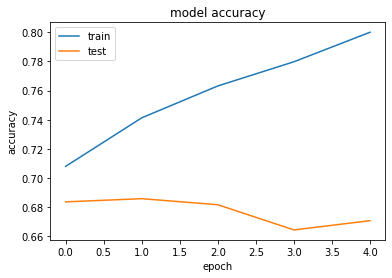

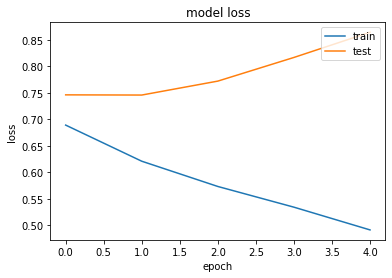

In [19]:
# Plotting accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()